# Facemask Detection Datathon

## Importing data science libraries

In [45]:
# import the necessary packages
import os                    # OS module in Python provides a way of using operating system dependent functionality
import pandas as pd          # Data analysis and manipultion tool
import numpy as np           # Fundamental package for linear algebra and multidimensional arrays
import matplotlib.pyplot as plt   # for visualization
import cv2                        # Library for image processing
import argparse
from imutils import paths
from tqdm.notebook import tqdm # widget progress bar
# Scikit-learn utils..
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import train_test_split    # For splitting the data into train and validation set

#Deep Learning Tool
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import models  
from keras.models import load_model
from keras.layers.convolutional import Conv2D
from keras.layers import Activation
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

## Loading and preparing training data

In [2]:
path = os.getcwd()
training_set_path = path + '\\Training_set_face_mask.csv'
labels = pd.read_csv(training_set_path)   # loading the labels
labels.head()                             # will display the first five rows in labels dataframe

,filename,label
0,Image_1.jpg,without_mask
1,Image_2.jpg,without_mask
2,Image_3.jpg,without_mask
3,Image_4.jpg,without_mask
4,Image_5.jpg,without_mask


In [3]:
labels.tail()            # will display the last five rows in labels dataframe

,filename,label
11259,Image_11260.jpg,with_mask
11260,Image_11261.jpg,with_mask
11261,Image_11262.jpg,with_mask
11262,Image_11263.jpg,with_mask
11263,Image_11264.jpg,with_mask


#### Getting image's filepath

In [4]:
file_paths = [[fname, path + '\\train\\' + fname] for fname in labels['filename']]
print(file_paths[0])

['Image_1.jpg', 'C:\\Users\\perro\\Documents\\deep_learning_final\\face_mask_detection\\train\\Image_1.jpg']


#### Confirming if number of labels is equal to number of images

In [5]:
# Confirm if number of images is same as number of labels given
if len(labels) == len(file_paths):
    print('Number of labels i.e. ', len(labels), 'matches the number of filenames i.e. ', len(file_paths))
else:
    print('Number of labels does not match the number of filenames')

Number of labels i.e.  11264 matches the number of filenames i.e.  11264


#### Converting the file_paths to dataframe



In [6]:
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
images.head()

,filename,filepaths
0,Image_1.jpg,C:\Users\perro\Documents\deep_learning_final\f...
1,Image_2.jpg,C:\Users\perro\Documents\deep_learning_final\f...
2,Image_3.jpg,C:\Users\perro\Documents\deep_learning_final\f...
3,Image_4.jpg,C:\Users\perro\Documents\deep_learning_final\f...
4,Image_5.jpg,C:\Users\perro\Documents\deep_learning_final\f...


#### Combining the labels with the images

In [7]:
train_data = pd.merge(images, labels, how = 'inner', on = 'filename')
train_data.head()

,filename,filepaths,label
0,Image_1.jpg,C:\Users\perro\Documents\deep_learning_final\f...,without_mask
1,Image_2.jpg,C:\Users\perro\Documents\deep_learning_final\f...,without_mask
2,Image_3.jpg,C:\Users\perro\Documents\deep_learning_final\f...,without_mask
3,Image_4.jpg,C:\Users\perro\Documents\deep_learning_final\f...,without_mask
4,Image_5.jpg,C:\Users\perro\Documents\deep_learning_final\f...,without_mask


## Data pre-processing 

#### Performing one-hot encoding on the labels

In [8]:
lb = LabelBinarizer()
labels_bin = lb.fit_transform(train_data.label) # categorical labels to binary
train_data["labels_bin"] = lb.fit_transform(train_data.label) # categorical labels to binary
labels_OHE =  to_categorical(labels_bin)  # One-Hot-Encoding for the labels binary

In [9]:
train_data.head()

,filename,filepaths,label,labels_bin
0,Image_1.jpg,C:\Users\perro\Documents\deep_learning_final\f...,without_mask,1
1,Image_2.jpg,C:\Users\perro\Documents\deep_learning_final\f...,without_mask,1
2,Image_3.jpg,C:\Users\perro\Documents\deep_learning_final\f...,without_mask,1
3,Image_4.jpg,C:\Users\perro\Documents\deep_learning_final\f...,without_mask,1
4,Image_5.jpg,C:\Users\perro\Documents\deep_learning_final\f...,without_mask,1


#### Shuffling input and target for optimum training

In [10]:
x = train_data['filepaths']
y = train_data['labels_bin']

x, y = shuffle(x, y, random_state=8)
print(y.head())

9529    0
2249    1
2071    1
2388    1
149     1
Name: labels_bin, dtype: int32


#### Function for Resizing and Reshaping the input images

In [11]:
def centering_image(img):
    
    size = [256,256]
    #shape:(h×w×t)taking the first2 elements(h,w) and unpacking them appropriately 
    img_size = img.shape[:2]
    
    # extracting the excess space for centering.
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    
    #creating centered image by taking a 0-matrix and then re-assigning intensities
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

#### Image resizing and converting them to an array

In [12]:

""" 
TQDM is a progress bar library. 
Inserting tqdm (or python -m tqdm)between pipes will pass 
through all stdin to stdout while printing progress to stderr
"""
images = []
with tqdm(total=len(train_data)) as pbar:
    for i, file_path in enumerate(train_data.filepaths.values):
        
        #read image
        img = cv2.imread(file_path,1)
        #color order is changed
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #print(img)

        #resize
        #converting images to square
        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        #centering the images
        img = centering_image(cv2.resize(img, dsize=tile_size))

        #out put 224*224px 
        img = img[16:240, 16:240]
        images.append(img)
        pbar.update(1)

images = np.array(images)

#### Re-Shuffling processed train data and converting to array


In [13]:
data_num = len(y)
random_index = np.random.permutation(data_num)

x_shuffle = []
y_shuffle = []
for i in range(data_num):
    x_shuffle.append(images[random_index[i]])
    y_shuffle.append(y[random_index[i]])
    
x = np.array(x_shuffle)
y = np.array(y_shuffle)

#### Train val split, oneHotVectorizing categories, input normalization

In [14]:
#Train val split
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
val_split_num = int(round(0.2*len(y)))

x_train = x[val_split_num:]
y_train = y[val_split_num:]

x_validation = x[:val_split_num]
y_validation = y[:val_split_num]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('########################')
print('x_test', x_validation.shape)
print('y_test', y_validation.shape)

# OneHotVectorizing categories
y_train = to_categorical(y_train)
y_validation = to_categorical(y_validation)

# Input normalization
x_train = x_train.astype('float32')
x_validation = x_validation.astype('float32')

x_train /= 255
x_validation /= 255

print('x_train Shape:', x_train.shape, '\t x_test Shape:',x_validation.shape)
print('y_train Shape: ', y_train.shape, '\t y_test Shape:',y_validation.shape)
print('image Shape:', x_train[0].shape)

x_train (9011, 224, 224, 3)
y_train (9011,)
########################
x_test (2253, 224, 224, 3)
y_test (2253,)
x_train Shape: (9011, 224, 224, 3) 	 x_test Shape: (2253, 224, 224, 3)
y_train Shape:  (9011, 2) 	 y_test Shape: (2253, 2)
image Shape: (224, 224, 3)


In [15]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [16]:

'''
# CONVOLUTIONAL ARCHITECTURE 
'''

learning_rate = 1e-4
epochs = 10

model = Sequential()
# first layer
model.add(Conv2D(32,(3,3), input_shape=(224, 224,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#second layer
model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))
# print(model.output_shape)
# print(model.summary())

opt = Adam(lr=learning_rate, decay=learning_rate / epochs)

model.compile(loss="binary_crossentropy", optimizer=opt, 
              metrics=["accuracy"])

#history = model.fit(data,target,epochs=1,validation_split=0.2)

# Summary of our model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 109, 109, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        1

## Train the head of the network


In [19]:
BS = 32

print("[INFO] training head...")

H = model.fit(
    aug.flow(x_train, y_train, batch_size=BS),
	steps_per_epoch=len(x_train) // BS,

	validation_data=(x_validation, y_validation),
	validation_steps=len(x_validation) // BS,
	epochs=epochs)

[INFO] training head...
Epoch 1/10
281/281 [==============================] - 277s 988ms/step - loss: 0.3219 - accuracy: 0.8635 - val_loss: 0.1668 - val_accuracy: 0.9414
Epoch 2/10
281/281 [==============================] - 262s 931ms/step - loss: 0.1929 - accuracy: 0.9308
Epoch 3/10
281/281 [==============================] - 272s 968ms/step - loss: 0.1844 - accuracy: 0.9312
Epoch 4/10
281/281 [==============================] - 266s 948ms/step - loss: 0.1808 - accuracy: 0.9340
Epoch 5/10
281/281 [==============================] - 262s 931ms/step - loss: 0.1710 - accuracy: 0.9408
Epoch 6/10
281/281 [==============================] - 263s 934ms/step - loss: 0.1642 - accuracy: 0.9409
Epoch 7/10
281/281 [==============================] - 354s 1s/step - loss: 0.1652 - accuracy: 0.9401
Epoch 8/10
281/281 [==============================] - 378s 1s/step - loss: 0.1568 - accuracy: 0.9451
Epoch 9/10
281/281 [==============================] - 378s 1s/step - loss: 0.1466 - accuracy: 0.9477
Epoch 1

In [20]:
H.history

{'loss': [0.32194966077804565,
  0.19289517402648926,
  0.1843528300523758,
  0.18084090948104858,
  0.17104454338550568,
  0.164242222905159,
  0.16524559259414673,
  0.15682485699653625,
  0.14657250046730042,
  0.14223794639110565],
 'accuracy': [0.8634591698646545,
  0.9308386445045471,
  0.9311727285385132,
  0.933957040309906,
  0.9407506585121155,
  0.9408619999885559,
  0.9400824308395386,
  0.945094108581543,
  0.9476556181907654,
  0.9486579895019531],
 'val_loss': [0.16682837903499603],
 'val_accuracy': [0.9414114356040955]}

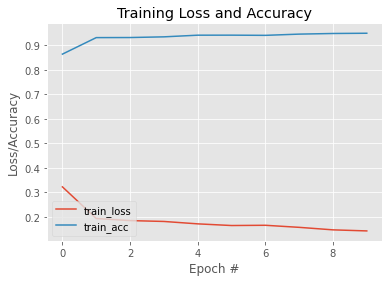

In [22]:
# plot the training loss and accuracy
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
#plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
#plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig(args["plot"])

In [23]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(x_validation, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(y_validation.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       0.97      0.96      0.97      1160
without_mask       0.96      0.97      0.96      1093

    accuracy                           0.97      2253
   macro avg       0.97      0.97      0.97      2253
weighted avg       0.97      0.97      0.97      2253



In [26]:
# saving the model
save_dir = path
model_name = '\\final.h5'
model_path = save_dir + model_name
model.save(model_path)
print('Saved trained model at %s ' % model_path)

C:\Users\perro\Documents\deep_learning_final\face_mask_detection
Saved trained model at C:\Users\perro\Documents\deep_learning_final\face_mask_detection\final.h5 


In [29]:
test_set_path = path + '\\Testing_set_face_mask.csv'
test_image_order = pd.read_csv(test_set_path)
test_image_order.head()

,filename,label
0,Image_1.jpg,NaN
1,Image_2.jpg,NaN
2,Image_3.jpg,NaN
3,Image_4.jpg,NaN
4,Image_5.jpg,NaN


In [30]:
file_paths = [[fname, path+ '//test//' + fname] for fname in test_image_order['filename']]
print(file_paths[0])

['Image_1.jpg', 'C:\\Users\\perro\\Documents\\deep_learning_final\\face_mask_detection//test//Image_1.jpg']


In [32]:
# Confirm if number of images is same as number of labels given
if len(test_image_order) == len(file_paths):
    print('Number of labels i.e. ', len(test_image_order), 'matches the number of filenames i.e. ', len(file_paths))
else:
    print('Number of labels does not match the number of filenames')

Number of labels i.e.  1536 matches the number of filenames i.e.  1536


In [33]:
# Converting the file_paths to dataframe
test_images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
test_images.head()

,filename,filepaths
0,Image_1.jpg,C:\Users\perro\Documents\deep_learning_final\f...
1,Image_2.jpg,C:\Users\perro\Documents\deep_learning_final\f...
2,Image_3.jpg,C:\Users\perro\Documents\deep_learning_final\f...
3,Image_4.jpg,C:\Users\perro\Documents\deep_learning_final\f...
4,Image_5.jpg,C:\Users\perro\Documents\deep_learning_final\f...


In [34]:
test_data = pd.merge(test_images, test_image_order, how = 'inner', on = 'filename')
test_data.head()

,filename,filepaths,label
0,Image_1.jpg,C:\Users\perro\Documents\deep_learning_final\f...,NaN
1,Image_2.jpg,C:\Users\perro\Documents\deep_learning_final\f...,NaN
2,Image_3.jpg,C:\Users\perro\Documents\deep_learning_final\f...,NaN
3,Image_4.jpg,C:\Users\perro\Documents\deep_learning_final\f...,NaN
4,Image_5.jpg,C:\Users\perro\Documents\deep_learning_final\f...,NaN


In [35]:
# Dropping the label column...
test_data.drop('label', axis = 1, inplace=True)

In [36]:
test_data.head()

,filename,filepaths
0,Image_1.jpg,C:\Users\perro\Documents\deep_learning_final\f...
1,Image_2.jpg,C:\Users\perro\Documents\deep_learning_final\f...
2,Image_3.jpg,C:\Users\perro\Documents\deep_learning_final\f...
3,Image_4.jpg,C:\Users\perro\Documents\deep_learning_final\f...
4,Image_5.jpg,C:\Users\perro\Documents\deep_learning_final\f...


In [37]:
# Image Resizing and converting them to array for test images of folder test
""" 
TQDM is a progress bar library. 
Inserting tqdm (or python -m tqdm)between pipes will pass 
through all stdin to stdout while printing progress to stderr
"""
tst_images = []
with tqdm(total=len(test_data)) as pbar:
    for i, file_path in enumerate(test_data.filepaths.values):
        
        #read image
        img = cv2.imread(file_path,1)
        
        #color order is changed
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #resize
        #converting images to square
        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        #centering the images
        img = centering_image(cv2.resize(img, dsize=tile_size))

        #out put 224*224px 
        img = img[16:240, 16:240]
        tst_images.append(img)
        pbar.update(1)

tst_images = np.array(tst_images)
tst_images = tst_images/255 # Normalization

In [48]:
tst_images.shape

(1536, 224, 224, 3)

In [49]:
model = load_model(path + '\\final.h5')

In [50]:
target = model.predict(tst_images)

In [51]:
names= ['with_mask', 'without_mask']

In [52]:
real_names1 = []
for i in range(0,1536):
    real_names1.append(str("'")+names[np.argmax(target[i])]+str("'"))


In [53]:
final_pd = pd.DataFrame(real_names1)
final_pd = final_pd.astype(str)
final_pd.index= test_data.index
final_pd.columns= ['target']
final_pd.head()

,target
0,'without_mask'
1,'with_mask'
2,'without_mask'
3,'without_mask'
4,'with_mask'


In [54]:
# Add the prediction column
test_data['label'] = real_names1
test_data.head()

,filename,filepaths,label
0,Image_1.jpg,C:\Users\perro\Documents\deep_learning_final\f...,'without_mask'
1,Image_2.jpg,C:\Users\perro\Documents\deep_learning_final\f...,'with_mask'
2,Image_3.jpg,C:\Users\perro\Documents\deep_learning_final\f...,'without_mask'
3,Image_4.jpg,C:\Users\perro\Documents\deep_learning_final\f...,'without_mask'
4,Image_5.jpg,C:\Users\perro\Documents\deep_learning_final\f...,'with_mask'


In [56]:
# save as CSV file
final_pd.to_csv(path + "\\prediction.csv",index=False, header=False)